In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
from scipy import stats

In [4]:
FILE_NAME = "../../data/radio_logs2019.csv"

sns.set_palette(sns.color_palette("colorblind"))
sns.set_style("darkgrid")

In [12]:
print("Reading data...")
data = pd.read_csv(FILE_NAME)
print(f"Data shape: {data.shape[0]} lines, {data.shape[1]} columns")

Reading data...
Data shape: 5529150 lines, 3 columns


In [13]:
data

,radio,sng_id,ts
0,Jazz Radio,14476372,2020-04-01 12:39:44.000
1,RTL2,9997018,2020-01-08 08:48:26.000
2,Ouï FM,9997018,2019-11-14 01:34:49.000
3,Contact FM,9997018,2018-12-21 13:00:24.000
4,Contact FM,9997018,2019-02-05 03:43:37.000
...,...,...,...
5529145,Contact FM,810557802,2020-03-20 01:00:00.000
5529146,Contact FM,810557802,2020-03-01 13:19:36.000
5529147,Champagne FM,810557802,2020-02-15 06:44:55.000
5529148,Champagne FM,810557802,2020-03-24 14:00:52.000


# Diversity

In [65]:
# Calculate S/P for each radio station
radio_groups = data.groupby(["radio", "sng_id"]).size()
ratios = radio_groups.groupby(["radio"]).size().divide(radio_groups.sum(level="radio")).to_frame().reset_index()
ratios.columns = ["radio", "S/P"]
ratios

,radio,S/P
0,ABC Lounge Jazz,0.015884
1,Alouette,0.024638
2,Beur FM,0.053563
3,Champagne FM,0.009632
4,Chante France,0.007186
5,Chí©rie FM,0.024188
6,Contact FM,0.017108
7,Djam Radio,0.044329
8,FG,0.050314
9,Fip,0.333282


In [6]:
ratios.to_csv("../../data/radio_diversity.csv", index=False)

In [304]:
ratios = pd.read_csv("../../data/radio_diversity.csv")

In [305]:
# sp_u = [sp_users[sp_users["bin_u"] == i+1] for i in range(4)]

# quantiles = [[spu["ratio"].quantile(i) for i in np.arange(.25, 1, .25)] for spu in sp_u]
# quantiles = [pd.DataFrame(q) for q in quantiles]
# for idx, q in enumerate(quantiles):
#     q["type"] = idx+1
#     q["radio"] = ["Q1", "Median", "Q3"]
#     q.rename(columns={0: "S/P"}, inplace=True)

# # Adding users to radio ratios -- with separation
# ratios["type"] = 0
# ratios = pd.concat([ratios, *quantiles])  # First time using this stuff for non-meme reason
# ratios

In [306]:
# Fetching user ratios
sp_users = pd.read_csv("../../data/sp_ratios_full.csv")

quantiles = [sp_users["ratio"].quantile(i) for i in np.arange(.25, 1, .25)]
quantiles = pd.DataFrame(quantiles)
quantiles["type"] = "user"
quantiles["radio"] = ["Q1", "Median", "Q3"]
quantiles.rename(columns={0: "S/P"}, inplace=True)

# Adding users to radio ratios -- with separation
ratios["type"] = "radio"
ratios = pd.concat([ratios, quantiles])
ratios

,radio,S/P,type
0,ABC Lounge Jazz,0.015884,radio
1,Alouette,0.024638,radio
2,Beur FM,0.053563,radio
3,Champagne FM,0.009632,radio
4,Chante France,0.007186,radio
5,Chí©rie FM,0.024188,radio
6,Contact FM,0.017108,radio
7,Djam Radio,0.044329,radio
8,FG,0.050314,radio
9,Fip,0.333282,radio


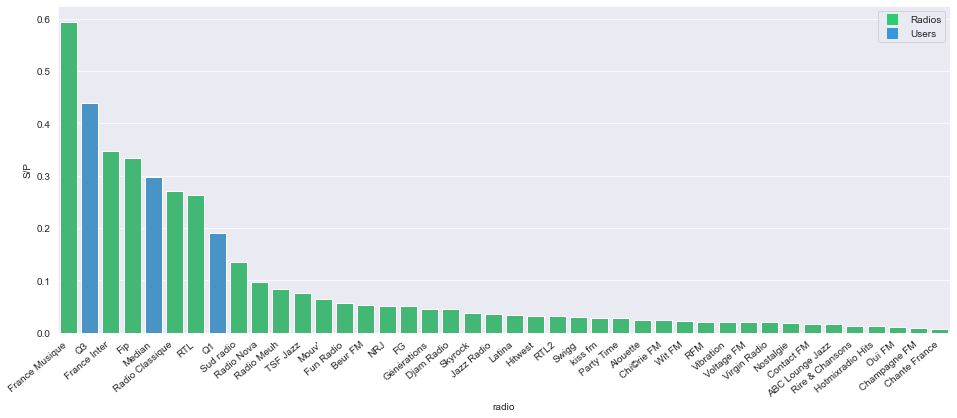

In [307]:
# Sorting for visual effect
ratios.sort_values("S/P", ascending=False, inplace=True)
clrs = ["#2ecc71" if x == "radio" else "#3498db" for x in ratios["type"]]

f, ax = plt.subplots(figsize=(16, 6))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
# Plotting in two separate 
bars = sns.barplot(x="radio", y="S/P", data=ratios, palette=clrs)

# Custom legends are a pain
radios_line = mlines.Line2D([], [], color="#2ecc71", marker="s", linestyle='None',
                          markersize=10, label="Radios")
users_line = mlines.Line2D([], [], color="#3498db", marker="s", linestyle='None',
                          markersize=10, label="Users")
ax.legend(handles=[radios_line, users_line])
# ax.legend(["users", "radios"], loc='upper right', frameon=False)

plt.savefig("../../results/radio/radios_sp.pdf")

In [29]:
# Reproduction de la figure 1b) -- S/P en fonction de P
radio_logp = np.log(data.groupby("radio").size()).to_frame().reset_index().rename(columns={0: "logp"})
radio_logp = ratios.merge(radio_logp, on="radio")

radio_logp["quantile"] = pd.cut(radio_logp["logp"], np.arange(9.5, 13.5, 1))

plays_means = radio_logp.groupby(["quantile"]).mean()["S/P"].to_frame().reset_index().drop("quantile", axis=1)
plays_means["logp"] = np.arange(10, 13, 1)
plays_means

,S/P,logp
0,0.198582,10
1,0.192082,11
2,0.044283,12


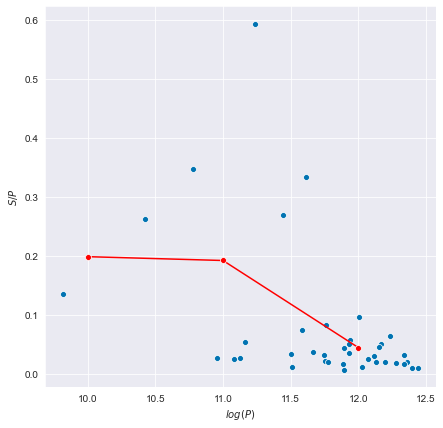

In [31]:
f, ax = plt.subplots(figsize=(7, 7))
sns.scatterplot(x="logp", y="S/P", data=radio_logp)
sns.lineplot(x="logp", y="S/P", data=plays_means, color="r", marker= "o")
ax.set(ylabel="$S/P$", xlabel="$log(P)$")
plt.savefig("../../results/radio/sp_logp_bins_radio.pdf")

# Mainstream

In [7]:
import nbimporter
import mainstream_tests

In [14]:
data

,radio,sng_id,ts
0,Jazz Radio,14476372,2020-04-01 12:39:44.000
1,RTL2,9997018,2020-01-08 08:48:26.000
2,Ouï FM,9997018,2019-11-14 01:34:49.000
3,Contact FM,9997018,2018-12-21 13:00:24.000
4,Contact FM,9997018,2019-02-05 03:43:37.000
...,...,...,...
5529145,Contact FM,810557802,2020-03-20 01:00:00.000
5529146,Contact FM,810557802,2020-03-01 13:19:36.000
5529147,Champagne FM,810557802,2020-02-15 06:44:55.000
5529148,Champagne FM,810557802,2020-03-24 14:00:52.000


In [15]:
songs = pd.read_csv("../../data/songs_artists_full.csv")
data = data.merge(songs, on="sng_id")

AttributeError: Can only use .dt accessor with datetimelike values

In [18]:
data["ts"] = pd.to_datetime(data["ts"]).dt.date
data["year"] = data["ts"].map(lambda x: x.year)
data["month"] =  data["ts"].map(lambda x: x.month)
data

,radio,sng_id,ts,art_id,year,month
0,Jazz Radio,14476372,2020-04-01,7962,2020,4
1,Jazz Radio,14476372,2020-02-06,7962,2020,2
2,Jazz Radio,14476372,2020-03-04,7962,2020,3
3,Jazz Radio,14476372,2019-12-12,7962,2019,12
4,Jazz Radio,14476372,2020-03-17,7962,2020,3
...,...,...,...,...,...,...
5529145,TSF Jazz,17759680,2019-06-03,56582,2019,6
5529146,France Musique,718131932,2020-03-07,8393128,2020,3
5529147,Fip,850992,2018-12-25,146114,2018,12
5529148,France Musique,698744072,2019-10-02,1617447,2019,10


In [19]:
radio_range = list(np.arange(0, 25000, 1))
sampled_data = data[data["year"] == 2019].sort_values("ts").groupby("radio", as_index=False).nth(radio_range)

In [20]:
BIN_AMNT = 4
# Binning -- see mainstream_tests.ipynb
sampled_data = mainstream_tests.bin_artists(sampled_data, bin_amnt=BIN_AMNT)

# Reversing bin numbers -- just a dirty little workaround to have the "mainstreamest" bin be 1
sampled_data["bin_nb"] = BIN_AMNT+1 - sampled_data["bin_nb"]

# Occurences of music plays in each bin
bin_distrib = sampled_data.groupby("bin_nb").size()

# Normalized
bin_distrib /= bin_distrib.sum()

Counting artist occurences...
Binning artists...
Number of artists per bin: 
bin
(-928.222, 232306.5]    24427
(232306.5, 464612.0]      996
(464612.0, 696917.5]      227
(696917.5, 929223.0]       65
dtype: int64
Artists binned into 4 categories.


In [173]:
radio_bins = sampled_data[(sampled_data["radio"] == "Fip") | (sampled_data["radio"] == "Contact FM")].groupby(["radio", "bin_nb"]).size().to_frame().reset_index()
radio_bins.columns = ["radio", "bin_nb", "amount"]
radio_bins

,radio,bin_nb,amount
0,Contact FM,1,13506
1,Contact FM,2,7004
2,Contact FM,3,3514
3,Contact FM,4,976
4,Fip,1,351
5,Fip,2,1753
6,Fip,3,4924
7,Fip,4,17972


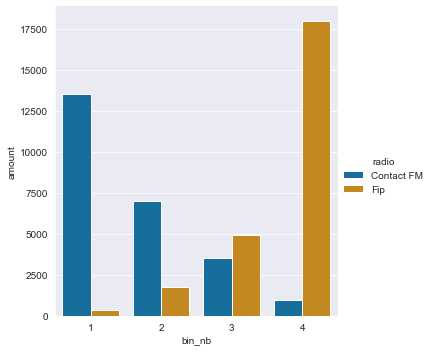

In [174]:
sns.catplot(x="bin_nb", y="amount", data=radio_bins, kind="bar", hue="radio")

## Figure 7-like

KeyError: "None of [Int64Index([ 47, 107,  39,  31,   3,  43, 111, 103,  67, 131,  71,  11,  95,\n             83,  35, 123,  87,  75,  55, 139,   7,  51,  99, 127,  19,  79,\n            151,  63,  91,  23, 119, 143,  59,  15, 147,  27, 135, 115],\n           dtype='int64')] are in the [columns]"

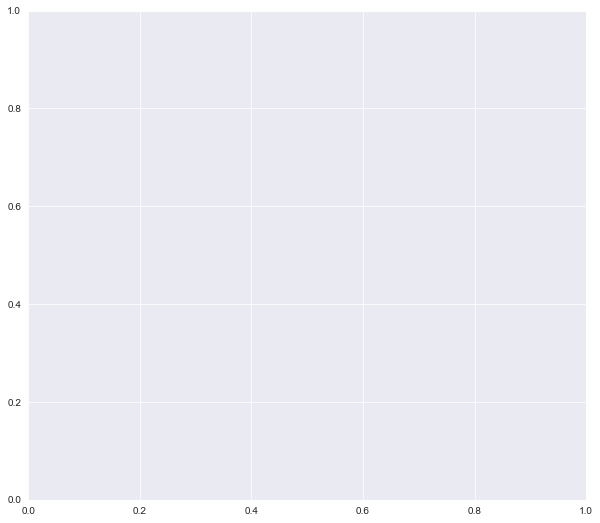

In [86]:
user_frame = sampled_data.groupby(["radio", "bin_nb"]).size().to_frame()
user_frame.columns = ["ratio"]

# Our user_frame ends up with [user, bin_nb, ratio]
user_plays = user_frame["ratio"].sum(level=0)
# user_frame = user_frame.unstack('bin_nb').divide(bin_distrib, level=1).divide(user_plays, axis=0).stack("bin_nb")
user_frame = user_frame.unstack('bin_nb').divide(user_plays, axis=0).stack("bin_nb")

user_frame = user_frame.reset_index()


f, ax = plt.subplots(figsize=(10, 9))

user_frame["ratio"] *= 100
y_pos = np.arange(len(user_frame["radio"].unique()))

# Pre-sorting series (weirdly but trust me there's no better way)
indices_sorted = user_frame[user_frame["bin_nb"] == 4]["ratio"].sort_values(ascending=False).index

series = [user_frame.loc[indices_sorted+i]["ratio"].reset_index(drop=True) for i in range(4)]

ax.barh(y_pos, series[0], color=sns.color_palette("colorblind")[0])
ax.barh(y_pos, series[1], left=series[0], color=sns.color_palette("colorblind")[1])
ax.barh(y_pos, series[2], left=series[0] + series[1], color=sns.color_palette("colorblind")[2])
ax.barh(y_pos, series[3], left=series[0] + series[1] + series[2], color=sns.color_palette("colorblind")[3])

# ax.barh(y_pos, user_frame[user_frame["bin_nb"] == 4]["ratio"].reset_index(drop=True) + user_frame[user_frame["bin_nb"] == 1]["ratio"].reset_index(drop=True) + user_frame[user_frame["bin_nb"] == 2]["ratio"].reset_index(drop=True) + user_frame[user_frame["bin_nb"] == 3]["ratio"].reset_index(drop=True), left=user_frame[user_frame["bin_nb"] == 3]["ratio"].reset_index(drop=True))

ax.set_yticks(y_pos)
ax.set_xticks(np.arange(0, 101, 10))
ax.set_yticklabels(user_frame[user_frame["bin_nb"] == 4].sort_values("ratio", ascending=False)["radio"].unique())
ax.invert_yaxis()  # labels read top-to-bottom

bin1_line = mlines.Line2D([], [], color=sns.color_palette("colorblind")[0], marker="s", linestyle='None',
                          markersize=10, label="$bin_\mu 1$")
bin2_line = mlines.Line2D([], [], color=sns.color_palette("colorblind")[1], marker="s", linestyle='None',
                          markersize=10, label="$bin_\mu 2$")
bin3_line = mlines.Line2D([], [], color=sns.color_palette("colorblind")[2], marker="s", linestyle='None',
                          markersize=10, label="$bin_\mu 3$")
bin4_line = mlines.Line2D([], [], color=sns.color_palette("colorblind")[3], marker="s", linestyle='None',
                          markersize=10, label="$bin_\mu 4$")

ax.legend(handles=[bin1_line, bin2_line, bin3_line, bin4_line])
# ax.legend(["users", "radios"], loc='upper right', frameon=False)

plt.savefig("../../results/radio/radios_mainstream_distrib.pdf")

In [84]:
test = user_frame.groupby(["radio", "bin_nb"]).sum().unstack().reset_index()
test.columns = ["radio", "1", "2", "3", "4"]
test["S/P"] = [sampled_ratios[sampled_ratios["radio"] == radio]["S/P"].values[0] for radio in test["radio"]]
test.corr(method="spearman")

,1,2,3,4,S/P
1,1.000000,0.462439,-0.400613,-0.887503,-0.661304
2,0.462439,1.000000,-0.116971,-0.598348,-0.498769
3,-0.400613,-0.116971,1.000000,0.209553,0.016961
4,-0.887503,-0.598348,0.209553,1.000000,0.826603
S/P,-0.661304,-0.498769,0.016961,0.826603,1.000000


# S/P & mainstream

## Figure ??

In [67]:
# Calculate S/P for the same sample as mainstream
sampled_radio_groups = sampled_data.groupby(["radio", "sng_id"]).size()
sampled_ratios = sampled_radio_groups.groupby(["radio"]).size().divide(sampled_radio_groups.sum(level="radio")).to_frame().reset_index()
sampled_ratios.columns = ["radio", "S/P"]
sampled_ratios

,radio,S/P
0,ABC Lounge Jazz,0.073480
1,Alouette,0.075960
2,Beur FM,0.088800
3,Champagne FM,0.036320
4,Chante France,0.026600
5,Chí©rie FM,0.043600
6,Contact FM,0.035560
7,Djam Radio,0.203600
8,FG,0.086520
9,Fip,0.506920


In [122]:
sampled_ratios["change"] = (sampled_ratios["S/P"] - ratios[ratios["radio"] != "Party Time"].reset_index(drop=True)["S/P"]) / ratios[ratios["radio"] != "Party Time"].reset_index(drop=True)["S/P"]

In [163]:
bin_mu_delta = sampled_data.groupby("radio").mean()["bin_nb"] - 2
bin_mu_delta = bin_mu_delta.to_frame().reset_index()
bin_mu_delta = bin_mu_delta.merge(sampled_ratios, on="radio")
bin_mu_delta

,radio,bin_nb,S/P
0,ABC Lounge Jazz,1.548652,0.015884
1,Alouette,0.028289,0.024638
2,Beur FM,1.081799,0.053563
3,Champagne FM,-0.217692,0.009632
4,Chante France,0.316516,0.007186
5,Chí©rie FM,0.066717,0.024188
6,Contact FM,-0.167444,0.017108
7,Djam Radio,1.586213,0.044329
8,FG,0.645916,0.050314
9,Fip,1.713160,0.333282


In [164]:
# sp_mu_bins = np.arange(bin_mu_delta["bin_nb"].min(), bin_mu_delta["bin_nb"].max()+0.1, (bin_mu_delta["bin_nb"].max()-bin_mu_delta["bin_nb"].min()) / 4)
sp_mu_bins = np.arange(-.5, 2.2, .5)

bin_mu_delta["quantile"] = pd.cut(bin_mu_delta["bin_nb"], sp_mu_bins)

sp_mu_means = bin_mu_delta.groupby(["quantile"]).mean()["S/P"].to_frame().reset_index().drop("quantile", axis=1)

sp_mu_bins_points = []
for i in range(sp_mu_bins.size - 1):
    sp_mu_bins_points.append((sp_mu_bins[i] + sp_mu_bins[i+1]) / 2)

sp_mu_means["bin_nb"] = sp_mu_bins_points
sp_mu_means

,S/P,bin_nb
0,0.023508,-0.25
1,0.039053,0.25
2,0.085488,0.75
3,0.109079,1.25
4,0.182954,1.75


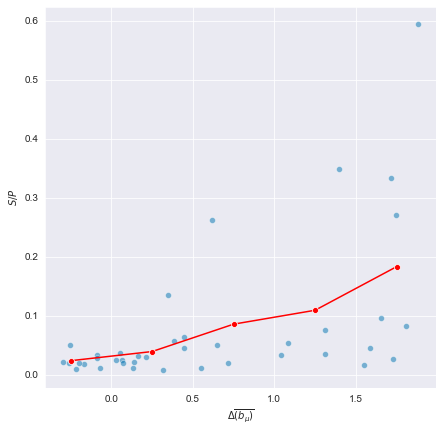

In [165]:
f, ax = plt.subplots(figsize=(7, 7))

sns.scatterplot(x="bin_nb", y="S/P", data=bin_mu_delta, alpha=0.5)
sns.lineplot(x="bin_nb", y="S/P", data=sp_mu_means, color="r", marker= "o")
ax.set(ylabel="$S/P$", xlabel="$\Delta\overline{(b_\mu)}$")

plt.savefig("../../results/radio/sp_deltamu_radios_2019_25000.pdf")

## Figure 6 ?